# Conformation Data Generation

## 1. Object
In this tutorial, we are going to:

- generate conformation from SMILES and perform MMFF optimization
- generate Gaussian input files for QM optimization
- submit Gaussian jobs
- post-process calculated results and prepare dataset

## 2. File organization

There will be a lot of files generated in this tutorial, therefore, it is important to organize them well.

A recommended way is to use these directories to store them:

- ./input: this folder stores your input smiles file
- ./record: for all the log files
- ./conformations: for generated conformations
- ./ginputs: storing separated condormation files (*.sdf), Gaussian input files (*.com and *.opt.com) and Gaussian ouput files (*.opt.log). This folder will contain extremely amout of files (4 times number of generated conformations).
- ./gjobs: for generated *.pbs files which can be directly submitted on SLURM server
- ./removed: Since some Gaussian jobs would fail, those failed files will be transported from ./ginputs to ./removed
- ./output: prepared dataset will be found here

Note that you don't need to create all of them manually since our code will take care of that.

## 3. SMILES -> Conformation

First we need to make a input directory

```
$ mkdir input
```

SMILES of molecules are given to our code through a csv file, which contains at least to columns: "index" and "SMILES". 

In this example, we use a truncated version of CCDC database which contains 5 molecules in total. Here "index" column is its ccdc_id.

```
$ cd input
$ wget SOME_URL
$ cd ..
```

Take a look at our input csv file:

In [1]:
import pandas as pd
input_csv = pd.read_csv('input/example.csv')
input_csv

,index,smiles,identifier,#HeavyAtoms,smiles_rdkit
0,33,COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C,ABABAH,20,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1
1,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,ABAFUG,20,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1
2,206,Cc1ccc(cc1)S(=O)(=O)NC1C(Cl)CC2COC1O2,ABANUP,20,Cc1ccc(S(=O)(=O)NC2C(Cl)CC3COC2O3)cc1
3,427,O=C1OC(N2C3C4CC(C=C4)C3C2=O)c2ccccc12,ABECEP,20,O=C1OC(N2C(=O)C3C4C=CC(C4)C32)c2ccccc21
4,515,CN(C)C(=O)Sc1c(C=O)cc(cc1C=O)C(C)(C)C,ABEHEV,20,CN(C)C(=O)Sc1c(C=O)cc(C(C)(C)C)cc1C=O


Then we generate conformations:

In [1]:
conformation_dir = './conformations'
record_dir = './record'

In [3]:
from DataGen.ez_conf_gen import gen_conf
gen_conf(smiles_csv_file='input/example.csv', source_data_name='ccdc', out_dir=conformation_dir,
        record_dir=record_dir, num_conf=10)

0 COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C
The total number of conformers after clustring: 10
1 COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1
The total number of conformers after clustring: 6
2 Cc1ccc(cc1)S(=O)(=O)NC1C(Cl)CC2COC1O2
The total number of conformers after clustring: 10
3 O=C1OC(N2C3C4CC(C=C4)C3C2=O)c2ccccc12
The total number of conformers after clustring: 10
4 CN(C)C(=O)Sc1c(C=O)cc(cc1C=O)C(C)(C)C
The total number of conformers after clustring: 10



Here we tried to generate 10 conformations for each of the molecules indicated in 'input/example.csv', generated conformations are stored in './conformations' folder and log file is in './record' folder:

In [5]:
import os
import os.path as osp
with open(osp.join(record_dir, 'genConf.log')) as f:
    for line in f.readlines():
        print(line, end='')

2020-07-07 15:59:37,533 index and smiles file loaded, generating conformations...
2020-07-07 15:59:37,533 total number of molecules queried: 5
2020-07-07 15:59:37,533 target number of conformations per molecule: 10
2020-07-07 15:59:38,645 0 of 5 molecule(s) failed.


## 4. Conformation -> Gaussian input

This step we seperate generated conformations and prepare them ready for Gaussian calculation:

In [2]:
gaussian_dir = '../ginput'
job_dir = './gjobs'
n_cpu = 2
mem = 1

Here we will generate Gaussian jobs requires 2 CPUs, 1GB memeory. 

We will generate SLURM jobs which run 2 Gaussian jobs per *.pbs file in 5 Hours with the same mount of memory.

You may need to optimize those parameters depending on the system to be investigated.

In [10]:
from DataGen.ez_conf_gen import gen_gaussian_input, gen_slurm_jobs
gen_gaussian_input(input_dir=conformation_dir, out_dir=gaussian_dir, record_dir=record_dir
                   , n_cpu=n_cpu, mem=mem)
gen_slurm_jobs(job_dir=job_dir, target_dir=gaussian_dir, num_jobs=2, time=5, mem=mem, n_cpu=n_cpu)

## 5. Submit jobs

You can automate this step with the sub_job function:
```python
from DataGen.genjob_hpc import sub_job
```

This step is simple but the most time comsuming part beacause of the relatively slow speed of QM calculation

## 6. Post analysis and prepare data

To prepare data, you need reference energy. For the method in this tutorial, it can be otained here:
```
$ cd input
$ wget SOME_URL
$ cd ..
```

In [3]:
output_dir = './output'

This prepare_dataset function will remove errors during Gaussian calculation, perform consistency check and prepare dataset ready for PhysNet input.

In [9]:
from DataGen.ez_conf_gen import prepare_dataset
prepare_dataset(data_dir='ginput', output_dir=output_dir, record_dir=record_dir,
                reference='input/atomref.B3LYP_631Gd.10As.npz', file_name='example')

Done! You can find generated data you need in output directory.

However, to build a better understanding of the data, let take a look at what have been done in this step:

First thing done in this function is that we removed errored files. Gaussian calculation may fail due to varied reasons, and our program will find those errors and remove them before we move on. Those removed files can be found in ./removed folder and also recorded in ./record/example_Gaussian_error.csv :

In [7]:
with open('record/example_Gaussian_error.csv') as f:
    for line in f.readlines():
        print(line, end='')

Fortunately, everything ended up correctly this time so the Gaussian error file is empty. 

Then we built a csv containing the information between conformations and original molecule id:

In [12]:
import pandas as pd
data = pd.read_csv('output/example_initial_dataset.csv', sep='\s+')
data.head()

,index,initial_index,SMILES,initial_InChI,initial_SMILES,MMFF_InChI,MMFF_SMILES,QM_InChI,QM_SMILES
0,1,33,COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1
1,10,33,COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1
2,11,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1
3,12,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1
4,13,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1


As can be seen, conformation index 1 and 10 corresponds initial molecule id 33, and 11, 12, 13 corresponds molecules 94, so on and so forth.

After that, we did a consistency check based on SMILES and InChI before and after calculation. We also checked radical and partial charge. Those conformations pass the consistency check will show up in the result csv files:

In [16]:
# Consitency check:
data = pd.read_csv('output/example_consistent_strict.csv', sep=',')
data.head()

,index,initial_index,SMILES,initial_InChI,initial_SMILES,MMFF_InChI,MMFF_SMILES,QM_InChI,QM_SMILES
0,1,33,COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1
1,10,33,COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1
2,11,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1
3,12,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1
4,13,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1


In [18]:
# Radical and partial charge (based on those pass the consistency check):
data = pd.read_csv('output/example_consistent_strict_rmrpc.csv', sep=',')
data.head()

,index,initial_index,SMILES,initial_InChI,initial_SMILES,MMFF_InChI,MMFF_SMILES,QM_InChI,QM_SMILES
0,1,33,COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1
1,10,33,COc1ccc(cc1)C1OC(=O)C(C)C1(C)CC(C)C,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1,InChI=1S/C17H24O3/c1-11(2)10-17(4)12(3)16(18)2...,COc1ccc(C2OC(=O)C(C)C2(C)CC(C)C)cc1
2,11,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1
3,12,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1
4,13,94,COc1ccc2c(c1)N(C(=C2C#N)C)c1ccccc1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1,InChI=1S/C17H14N2O/c1-12-16(11-18)15-9-8-14(20...,COc1ccc2c(C#N)c(C)n(-c3ccccc3)c2c1


Finally, those conformations passes those checks are prepared into dataset ready for training:

- example_target.csv records varied targets common in training, the index is the conformation index
- example_QM(MMFF).pt records a list <rdkit.mol> for each generated conformation
- example_QM(MMFF)_PhysNet.npz is the PhysNet input for generated conformations

In [19]:
# target.csv:
data = pd.read_csv('output/example_target.csv')
data.head()

,index,A,B,C,mu,alpha,ehomo,elumo,egap,R2,...,U0,U,H,G,Cv,E,U0_atom,U_atom,H_atom,G_atom
0,1,0.48341,0.20120,0.15807,5.6305,183.28,-0.183949,-5.977253,5.793304,7050.2361,...,-24151.749236,-24151.196192,-24151.170504,-24153.071355,78.455,-24162.172944,-190.078062,-191.220396,-192.325614,-176.492859
1,10,0.49664,0.19775,0.15763,3.8837,183.32,-0.171432,-5.960382,5.788950,7084.3376,...,-24151.754270,-24151.201824,-24151.176137,-24153.072662,78.439,-24162.179559,-190.083096,-191.226029,-192.331247,-176.494165
2,11,0.37953,0.31688,0.18256,7.9956,193.99,-0.885731,-5.453434,4.567703,5786.1173,...,-22876.328851,-22875.861251,-22875.835563,-22877.581664,65.990,-22883.674986,-165.156868,-165.999332,-166.847403,-154.396887
3,12,0.39734,0.28675,0.17571,6.0757,196.09,-0.832668,-5.384861,4.552193,6026.6876,...,-22876.310402,-22875.843591,-22875.817876,-22877.559513,65.982,-22883.658615,-165.138419,-165.981672,-166.829715,-154.374737
4,13,0.39734,0.28675,0.17571,6.0757,196.09,-0.832668,-5.384861,4.552193,6026.6860,...,-22876.310402,-22875.843591,-22875.817876,-22877.559513,65.982,-22883.658615,-165.138419,-165.981672,-166.829715,-154.374737


<class 'list'>
len: 45
first object: 


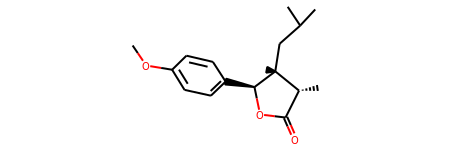

In [20]:
# example_QM(MMFF).pt
import torch
data = torch.load('output/example_QM.pt')
print(data.__class__)
print('len: {}'.format(len(data)))
print('first object: ')
data[0]

In [23]:
# example_QM(MMFF)_PhysNet.npz 
import numpy as np
data = np.load('output/example_QM_PhysNet.npz', allow_pickle=True)
print(data.files)
for entry in data.files:
    print('****{}****'.format(entry))
    print('shape: {}'.format(data[entry].shape))

['R', 'Q', 'D', 'E', 'F', 'Z', 'N']
****R****
shape: (45,)
****Q****
shape: (45,)
****D****
shape: (45, 3)
****E****
shape: (45,)
****F****
shape: (45, 20, 3)
****Z****
shape: (45,)
****N****
shape: (45,)


## 7. Utility functions
- tar_folder function will compress a folder into a single file for backup or transportation, untar function will 
reverse it:


```python
from DataGen.ez_conf_gen import tar_folder, untar
```

- concat_dataset function will concat multiple prepare dataset into a single one

```python
from DataGen.ez_conf_gen import concat_dataset
```